**Using GAN to upscale images from 128x128 to 256x256**

main paper : 

https://arxiv.org/abs/1609.04802

additional:

1. Неясено назначение слоя с поэлементным суммированием.

НАЙДЕНО https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec

2. pixelshuffle

https://arxiv.org/pdf/1609.05158.pdf

https://keras.io/examples/vision/super_resolution_sub_pixel/

3. Error

[I 15:39:11.255 NotebookApp] Kernel started: 7538191b-0709-49bd-8676-179ada99d89b, name: conda-env-tfdml_plugin-py
Active code page: 65001
CONDA_PREFIX=C:\Users\common\anaconda3
2023-06-28 15:40:41.120207: I tensorflow/c/logging.cc:34] Successfully opened dynamic library C:\Users\common\anaconda3\envs\tfdml_plugin\lib\site-packages\tensorflow-plugins/directml/directml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.dll
2023-06-28 15:40:41.120745: I tensorflow/c/logging.cc:34] Successfully opened dynamic library dxgi.dll
2023-06-28 15:40:41.130022: I tensorflow/c/logging.cc:34] Successfully opened dynamic library d3d12.dll
2023-06-28 15:40:41.451678: I tensorflow/c/logging.cc:34] DirectML device enumeration: found 1 compatible adapters.
2023-06-28 15:40:42.486950: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-28 15:40:42.487573: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (NVIDIA GeForce RTX 3060 Ti)
2023-06-28 15:40:42.575227: I tensorflow/c/logging.cc:34] Successfully opened dynamic library Kernel32.dll
2023-06-28 15:40:42.576303: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-28 15:40:42.576487: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:28] Overriding allow_growth setting because force_memory_growth was requested by the device.
2023-06-28 15:40:42.577142: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 13865 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2023-06-28 15:40:46.632291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-28 15:40:50.966559: F tensorflow/c/logging.cc:43] HRESULT failed with 0x80070057: dml_device->CreateOperator(&op_desc, IID_PPV_ARGS(&op))
[I 15:41:08.253 NotebookApp] KernelRestarter: restarting kernel (1/5), keep random ports
kernel 7538191b-0709-49bd-8676-179ada99d89b restarted

**IMPORTING LIBRARIES AND PACKAGES**

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt 
from tqdm import tqdm
import os
import datetime
from IPython.display import clear_output
import time

import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow version:", tf.__version__)

load_weights = False
weights_folder = "weights_modver/"
weights_file_index = "2023-06-06_13"

TRAINING = True

Num GPUs Available:  1
TensorFlow version: 2.10.0


**LOADING DATASET**

* using 256x256 images from MSCOCO dataset
* X is array containing input images generated by resizing original images to 128x128 size
* Y is array containing original images of 256x256 size
* Only 1000 images are used out of 80K images for faster computation

In [2]:
# secondary function

def parse(img, chunk, with_map=False):
    img_new = np.array(img)
    img_width = img_new.shape[0]
    img_height = img_new.shape[1]
    #print("shape", img_width, img_height)
    rows = img_height/chunk
    row_remainder = img_height%chunk
    columns = img_width/chunk
    column_remainder = img_width%chunk
    #print("remainders", row_remainder, column_remainder)
    rows, columns = int(rows), int(columns)
    start_r, start_c = int(row_remainder//2), int(column_remainder//2)
    #print("start position", start_r, start_c)

    img_new = [img_new[(start_c+j*chunk):(start_c+j*chunk)+chunk, 
                       (start_r+i*chunk):(start_r+i*chunk)+chunk] for i in range(rows) for j in range(columns)]
    if with_map:
        return({"img":img_new, "map":(rows,columns)})
    return img_new

def rebuild_img(v0chunks, img_map):
    chunks = np.array(v0chunks)
    face = chunks.shape[-2]
    temp = np.zeros((face*img_map[-1], face*img_map[0],3))
    
    for y in range(img_map[-1]):
        for x in range(img_map[0]):
            temp[face*y:face*(y+1), face*x:face*(x+1)] = chunks[x*img_map[0]+y]
            
    temp = np.uint8(temp)
    
    assert (temp.shape[:-1] == np.array(img_map)*face).all
    
    return temp

  0%|▏                                       | 22/4918 [00:00<00:39, 124.69it/s]


Batch size:  52
waste:  0
input train (42, 1, 128, 128, 3)
target train (42, 1, 256, 256, 3)
input test (10, 1, 128, 128, 3)
target test (10, 1, 256, 256, 3)


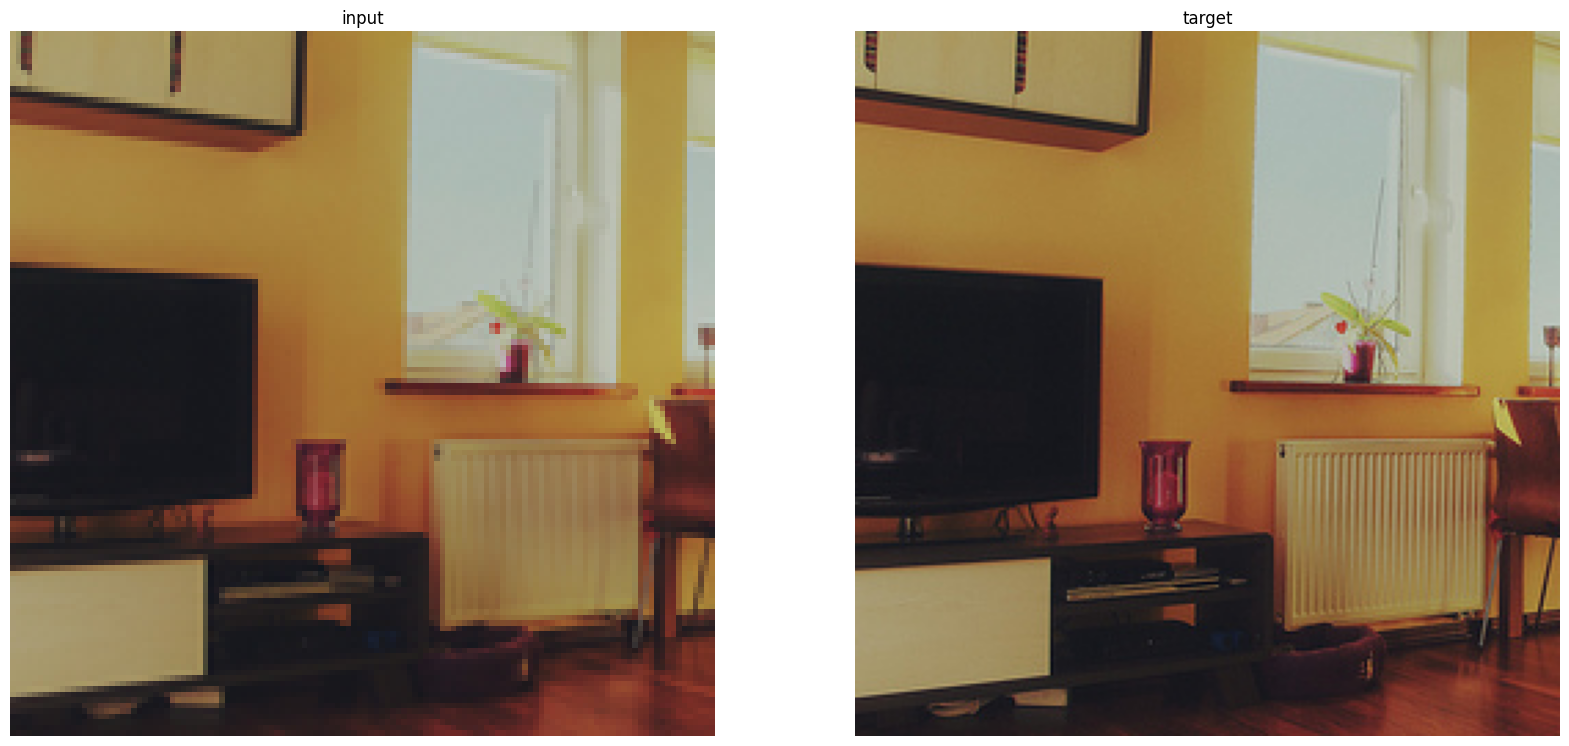

In [3]:
def load_data():
    X = []
    Y = []
    n = 0

    batch_size = 0
    junk = 0
    dirname = r"C:\Users\common\source\Jupyter\GAN based image upscaling\mscoco\mscoco_resized\val2017"

    try:
      os.mkdir(weights_folder)
    except FileExistsError:
      pass

    for filename in tqdm(os.listdir(dirname)):
        im  = Image.open(os.path.join(dirname, filename))

        if any([shape < 256 for shape in np.array(im).shape[:2]]):
            junk += 1
            continue
        im = parse(im, 256)
        for chunk in im:
            image = Image.fromarray(chunk)
            image = image.convert("RGB")
            image = image.resize((256,256))
            assert np.array(image).shape == (256,256,3)
            Y.append(np.array(image))

            batch_size += 1
            image = image.resize((128,128))
            X.append(np.array(image))
        #
        if batch_size > 50: break


    print("Batch size: ", batch_size)
    print("waste: ", junk)

    X = np.array(X, dtype = 'float32')
    Y = np.array(Y, dtype = 'float32')
    X = (X/127.5)-1
    Y = (Y/127.5)-1 
    #===================================display=======================================
    display_list = [np.array((X[n]+1)*127.5, dtype='int'),np.array((Y[n]+1)*127.5, dtype='int')]
    title_list = ['input','target']
    plt.figure(figsize = (20,20))

    for i in range(2):
        plt.subplot(1,2,i+1)
        plt.title(title_list[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    #=================================================================================
    X_train = X[:-10].reshape(-1,1,128,128,3)
    Y_train = Y[:-10].reshape(-1,1,256,256,3)
    X_test = X[-10:].reshape(-1,1,128,128,3)
    Y_test = Y[-10:].reshape(-1,1,256,256,3)
    
    return {"X_train":X_train, 
            "Y_train":Y_train, 
            "X_test":X_test, 
            "Y_test":Y_test}

if TRAINING == True:
    temp = load_data()
    
    X_train = temp["X_train"]
    Y_train = temp["Y_train"]
    X_test = temp["X_test"]
    Y_test = temp["Y_test"]

    print("input train", X_train.shape)
    print("target train", Y_train.shape)

    print("input test", X_test.shape)
    print("target test", Y_test.shape)

**CREATING GENERATOR MODEL**

* GAN uses two models, a generator model that generates output and a discriminator model that classifies wether the output is generated by the generator model(fake) or taken from the dataset(real)

* The generator model is a U-Net. It is a neural network used for image to image tasks. It has three major components : downsampling blocks, upsampling blocks and skip connections.

* Downsampling blocks convert image input to tensors of lower dimesions until it becomes a 1D tensor. Upsampling blocks convert output of downsampling blocks back to image output. Skip connections provide connections between downsampling and upsampling blocks at each level.

* Generator and discriminator compete against each other.

In [4]:
def generator_block(filters, size, apply_batchnorm = True):
    initializer = tf.random_normal_initializer(0. , 0.02)
    
    result = tf.keras.Sequential()
    
    result.add(tf.keras.layers.Conv2D(filters, 
                                      size, 
                                      strides=1, 
                                      padding='same',
                                      kernel_initializer=initializer, 
                                      use_bias=False)) 
    result.add(tf.keras.layers.BatchNormalization())    
    result.add(tf.keras.layers.PReLU())
    result.add(tf.keras.layers.Conv2D(filters, 
                                      size, strides=1, 
                                      padding='same',
                                      kernel_initializer=initializer, 
                                      use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
        
    return result


def discriminator_block(filters, size, strides = 2, apply_dropout = True):
    initializer = tf.random_normal_initializer(0. , 0.02)
    
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides, padding='same',kernel_initializer=initializer, use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    return result
    
def pixelshuffler(filters, size, in_shape, up_factor=2, channels=3):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    #inputs=tf.Tensor(shape=(None, 128, 128, 64), dtype=float32)
    inputs = tf.keras.Input(shape=in_shape)
    x = tf.keras.layers.Conv2D(
        filters, 
        size, 
        **conv_args)(inputs)
    x = tf.keras.layers.Conv2D(
        channels * (up_factor ** 2), 
        size, 
        **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, up_factor)

    return tf.keras.Model(inputs, outputs)

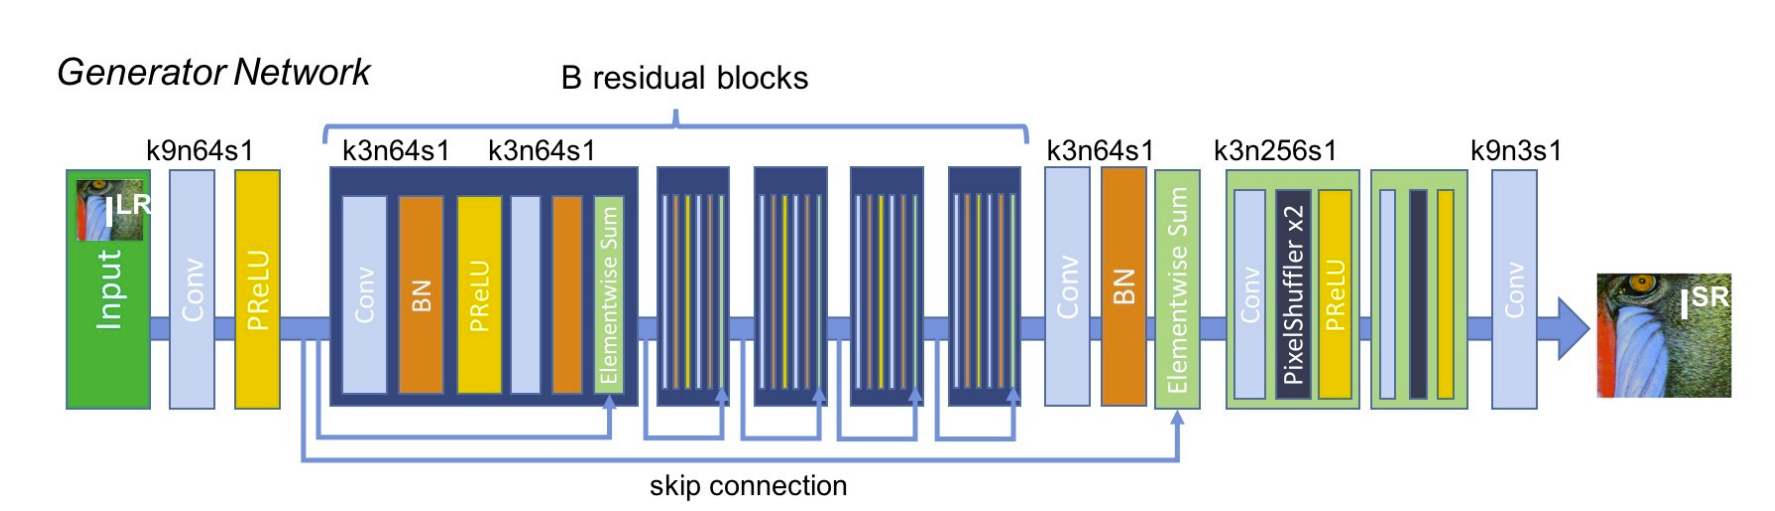

In [5]:
def Generator():   
    conv_args = {
        "kernel_initializer": tf.random_normal_initializer(0., 0.02),
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    
    b_residual_block = [
    generator_block(64,3),#1
    generator_block(64,3),#2
    generator_block(64,3),#3
    generator_block(64,3),#4
    generator_block(64,3),#5
    ]
        
    inp = tf.keras.layers.Input(shape=[128,128,3], name='input_image')
    x = tf.keras.layers.Conv2D(filters=64, 
                               kernel_size=9, 
                               strides=1, 
                               **conv_args)(inp)
    
    temp = tf.keras.layers.PReLU()(x)
    
    x = tf.keras.layers.PReLU()(x)
    for layer in b_residual_block:
        x = tf.math.add(x, layer(temp))
        
    x = tf.keras.layers.Conv2D(filters=64, 
                               kernel_size=3, 
                               strides=1, 
                               **conv_args)(x) 
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.math.add(x, temp)
    
    x = pixelshuffler(
        filters=256,
        size=3,
        in_shape=(128, 128, 64))(x)
    x = tf.keras.layers.Conv2D(
        filters=3, 
        kernel_size=9, 
        strides=1, 
        **conv_args)(x) 
    
    return tf.keras.Model(inputs = inp, outputs = x, name="generator")

In [6]:
generator = Generator()

if load_weights and weights_file_index != None:
    generator.load_weights(weights_folder + "generator_" + weights_file_index)
    
tf.keras.utils.plot_model(generator, show_shapes = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


**GENERATOR LOSS**

* Generator loss consists of two components
* L1 loss which is mean absolute error between the generated image and target image to make generated images structurally similar to target images
* GAN loss which is binary crossentropy loss of discriminator's output on generated images and array of ones.
* Total loss = GAN loss + (LAMBDA * L1 loss)

In [7]:
LAMBDA = 500
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits = False)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    
    l1_loss = tf.reduce_mean(tf.abs(target-gen_output))
    
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    
    return total_gen_loss

**CREATING DISCRIMINATOR MODEL**

* Discriminator model is a PatchGAN
* In a PatchGAN, the output is a 3D vector referring to similarity between patches of input and target images
* Model consists of downsampling blocks : Conv->BatchNorm->LeakyReLU
* It receives two inputs : Input image and generated image which is classified as fake and input image and target image which is classified as real


In [8]:
def Discriminator():
    inputs = tf.keras.layers.Input(shape = [256,256,3])
    initializer = tf.random_normal_initializer(0. , 0.02)

    #discriminator_block
    #feature map x2 each layer, 
    #kernel 3x3, 
    #strides on every second layer that downsampling image
    down_stack = [
        tf.keras.layers.Conv2DTranspose(64,3,strides=1,padding='same',kernel_initializer = initializer,activation = 'tanh'),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        discriminator_block(64, 3, 2, apply_dropout = True), 
        discriminator_block(128, 3, 1, apply_dropout = True),
        discriminator_block(128, 3, 2, apply_dropout = True),
        discriminator_block(256, 3, 1, apply_dropout = True),
        discriminator_block(256, 3, 2, apply_dropout = True), 
        discriminator_block(512, 3, 1, apply_dropout = True), 
        discriminator_block(512, 3, 2, apply_dropout = True),
        tf.keras.layers.Dense(1024),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Dense(1)
    ]

    x = inputs
    for down in down_stack:
        x = down(x)
    x = tf.math.sigmoid(x)
    
    return tf.keras.Model(inputs = inputs, outputs = x, name="discriminator")

In [9]:
discriminator = Discriminator()

if load_weights and weights_file_index != None:
    discriminator.load_weights(weights_folder + "discriminator_" + weights_file_index)
    
tf.keras.utils.plot_model(discriminator, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


**DISCRIMINATOR LOSS**

* It takes two inputs : discriminator output for real images and generated images and it has two components : real loss and generated loss
* real loss is sigmoid cross entropy loss of real image output and array of ones
* generated loss is sigmoid cross entropy loss of generated image output and array of zeros
* total loss is sum of real loss and generated loss

In [10]:
def discriminator_loss(disc_real_output, disc_gen_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    
    gen_loss = loss_object(tf.zeros_like(disc_gen_output), disc_gen_output)
    
    return real_loss + gen_loss

**OPTIMIZERS AND CHECKPOINT SAVER**

In [11]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)

checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir,"ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                discriminator_optimizer = discriminator_optimizer,
                                generator = generator,
                                discriminator = discriminator)


**FUNCTION TO GENERATE IMAGES**

In [12]:
def generate_images(model, inp, tar):
    inp_normalized = (inp/127.5)-1
    pred = model(inp_normalized, training = True)
    
    #pred = Image.fromarray(tar[0].astype('uint8'),'RGB')
    pred = (pred+1)*127.5
    display_list = [np.array(inp[0], dtype='int'),np.array(pred[0], dtype='int'),np.array(tar[0], dtype='int')]
    title_list = ['input','prediction','target']
    plt.figure(figsize = (20,20))
    
    for i in range(3):
        plt.subplot(1,3,i+1)
        plt.title(title_list[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    
    plt.show()




**TRAINING**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


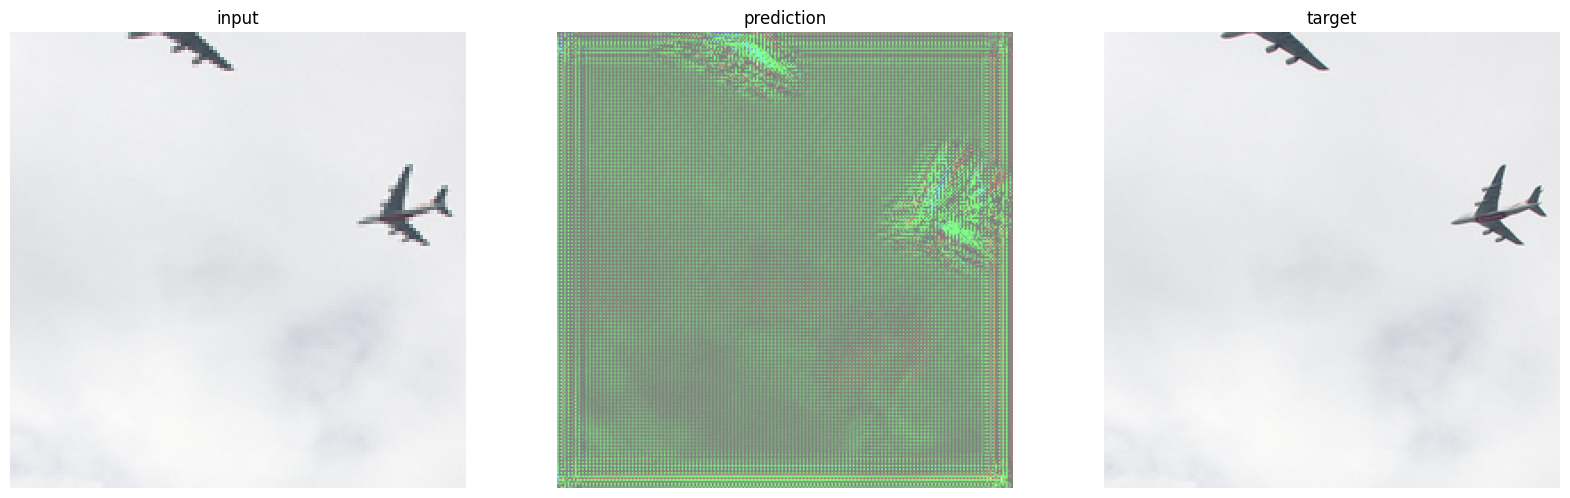

1


0it [00:00, ?it/s]

In [ ]:
EPOCHS = 2
@tf.function
def train_step(inp, tar, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(inp, training = True)
    
        disc_real_output = discriminator(tar, training = True)
        disc_gen_output = discriminator(gen_output, training = True)
    
        gen_loss = generator_loss(disc_gen_output, gen_output, tar)
        disc_loss = discriminator_loss(disc_real_output, disc_gen_output)
    
    gen_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))

def fit(X_train, Y_train, X_test, Y_test, epochs):
    for epoch in range(epochs):
        clear_output(wait = True)
        generate_images(generator, (X_test[0]+1)*127.5, (Y_test[0]+1)*127.5)
        print("1")
        for inp,tar in tqdm(zip(X_train, Y_train)):
            assert inp.shape == (1, 128, 128, 3), f"expected shape (1,128,128,3), got: {inp.shape}"
            train_step(inp, tar, epoch)
        print("3")
        if (epoch+1)%10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
    checkpoint.save(file_prefix=checkpoint_prefix)

if TRAINING == True:
    fit(X_train, Y_train, X_test, Y_test, EPOCHS)

In [ ]:
filename_input = r"C:\Users\common\Pictures\spitz\input.jpg"
target_img = Image.open(filename_input)

parsed_img = parse(target_img, 128, with_map=True)
for i,piece in enumerate(parsed_img["img"]):
    piece = piece.reshape(-1,128,128,3)
    parsed_img["img"][i] = np.uint8((generator((piece/127.5)-1)+1)*127.5)
result = rebuild_img(parsed_img["img"], parsed_img["map"])
result = Image.fromarray(result)
plt.figure(figsize = (10,10))
plt.imshow(result)
plt.axis('off')
plt.show() 
name = r"C:\Users\common\Pictures\spitz\Prince_result.jpg"
result.save(name)

In [ ]:
if TRAINING == True:
    from datetime import datetime
    now = datetime.now()

    discriminator.save_weights(weights_folder + 'discriminator' + now.strftime("_%Y-%m-%d_%H"))
    generator.save_weights(weights_folder + 'generator' + now.strftime("_%Y-%m-%d_%H"))

    print("files:\n",
         'discriminator' + now.strftime("_%Y-%m-%d_%H"),"\n",
         'generator' + now.strftime("_%Y-%m-%d_%H"))
